# Setting

In [1]:
from pf_utils import BacktestManager, DataManager, MomentumPortfolio

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [136]:
metrics2 = [
    'cagr', 'monthly_vol', 'monthly_sharpe',
    'max_drawdown', 'avg_drawdown','avg_drawdown_days', 
]

path_data = 'data'
path_tran = 'transaction'

# Universe

## KOSPI200

In [3]:
k200 = DataManager(
    file = 'kospi200_prices_240708.csv',
    universe = 'KOSPI200',
    path = path_data
)
k200.upload()

200 assets from 2021-01-04 to 2024-07-08 uploaded.
df_prices updated


In [4]:
# uncomment download to update prices
kw = dict(
    n_years=3, 
    #tickers=k200.df_prices.columns
)
#k200.download(**kw)

In [5]:
df_k200 = k200.df_prices
assetnames_k200 = k200.get_names()

## ETF

In [6]:
etf = DataManager(
    file = 'etfs_all_240708.csv',
    universe = 'ETF',
    path = path_data
)
etf.upload()

864 assets from 2021-01-04 to 2024-07-08 uploaded.
df_prices updated


In [7]:
# uncomment download to update prices
kw = dict(
    n_years=3, 
    #tickers=etf.df_prices.columns
)
#etf.download(**kw)

In [8]:
choice = ['069500', '273130', '148070', '379800', '411060', '284430']
df_etf = etf.df_prices[choice]
assetnames_etf = etf.get_names(tickers=choice)
assetnames_etf

0) 069500: KODEX 200
1) 273130: KODEX 종합채권(AA-이상)액티브
2) 148070: KOSEF 국고채10년
3) 379800: KODEX 미국S&P500TR
4) 411060: ACE KRX금현물
5) 284430: KODEX 200미국채혼합

# Backtest

## KOSPI 200

In [18]:
kwargs_bm = dict(
    initial_capital = 10000000,
    commissions = 0,
    align_axis = 1, 
    days_in_year = 246,
    asset_names = assetnames_k200
)
bm = BacktestManager(df_k200, **kwargs_bm)

15 assets removed for shorter periods (7.5%)
running self.util_check_days_in_year to check days in a year


In [19]:
bm.benchmark_ticker()

Benchmark is KODEX200
RunOnce selected


In [10]:
kwargs_build = dict(
    name = 'Momentum',
    freq = 'M', select = 'Momentum', weigh = 'ERC',
    n_assets=5, lookback=12, lag=12
)
bm.build(**kwargs_build)

In [11]:
kwargs_build = dict(
    name = 'K-ratio',
    freq = 'M', select = 'K-ratio', weigh = 'ERC',
    n_assets=5, lookback=12, lag=12
)
bm.build(**kwargs_build)

Backtesting 3 strategies: KODEX200, Momentum, K-ratio


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:59<00:00, 19.69s/it]

Returning stats


,KODEX200,Momentum,K-ratio
start,2021-01-03,2021-01-03,2021-01-03
end,2024-07-05,2024-07-05,2024-07-05
cagr,0.016695,0.664683,0.230809
monthly_vol,0.185975,0.435543,0.262161
monthly_sharpe,0.157682,1.382685,0.922983
max_drawdown,-0.342432,-0.276901,-0.229503
avg_drawdown,-0.08767,-0.05712,-0.044447
avg_drawdown_days,210.666667,17.465116,29.296296


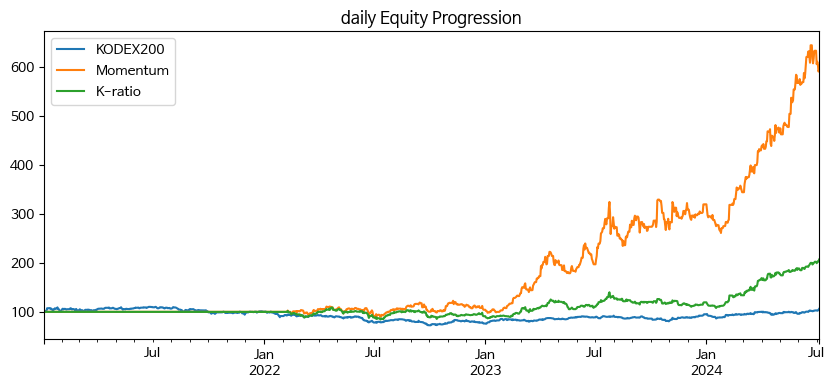

In [12]:
bm.run(figsize=(10,4), metrics=metrics2)

## ETF

In [23]:
kwargs_bm = dict(
    initial_capital = 10000000,
    commissions = 0,
    align_axis = 0, 
    days_in_year = 245,
    asset_names = assetnames_etf
)
bm = BacktestManager(df_etf, **kwargs_bm)

period reset: 2021-12-15 ~ 2024-07-05
running self.util_check_days_in_year to check days in a year


In [24]:
bm.benchmark_ticker()

Benchmark is KODEX200
RunOnce selected


### Weights

In [25]:
bm.build(
    name = 'COMB1: Eqaully',
    freq = 'Y', select = 'all', weigh = 'equally'
)

In [26]:
bm.build(
    name = 'COMB2: ERC',
    freq = 'Y', select = 'all', weigh = 'ERC', 
    lookback=12, lag=0
)

In [27]:
bm.build(    
    name = 'COMB3: InvVol',
    freq = 'Y', select = 'all', weigh = 'InvVol', 
    lookback=12, lag=0
)

Backtesting 4 strategies: KODEX200, COMB1: Eqaully, COMB2: ERC, COMB3: InvVol


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.44it/s]


Returning stats


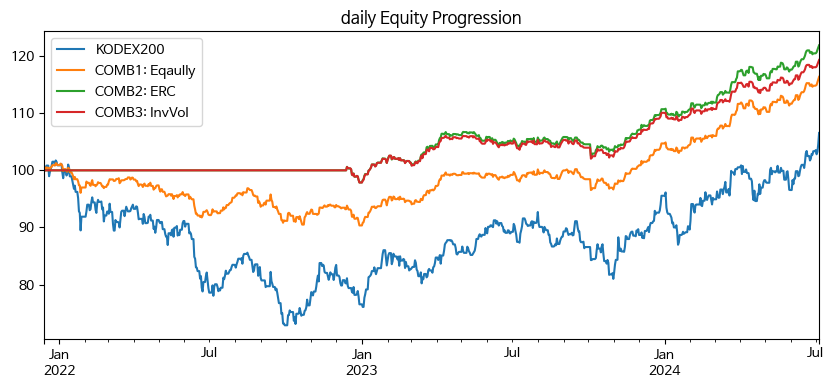

In [28]:
_ = bm.run(figsize=(10,4))

In [29]:
bm.get_stats(sort_by='monthly_sharpe', metrics=metrics2)

,COMB2: ERC,COMB3: InvVol,COMB1: Eqaully,KODEX200
start,2021-12-14,2021-12-14,2021-12-14,2021-12-14
end,2024-07-05,2024-07-05,2024-07-05,2024-07-05
cagr,0.080517,0.071554,0.061102,0.025121
monthly_vol,0.05538,0.054357,0.083106,0.207521
monthly_sharpe,1.414939,1.288041,0.7053,0.20433
max_drawdown,-0.039351,-0.03793,-0.107524,-0.283724
avg_drawdown,-0.007642,-0.007321,-0.01059,-0.066244
avg_drawdown_days,16.851852,18.6,41.142857,184.0


### Freq

In [30]:
kwargs_build = dict(
    select = 'all', weigh = 'ERC', 
    lookback=12, lag=0
)

kwa_list = [{'name':f'freq {x}', 'freq':x} for x in ['M', 'Q', 'Y']]

bm.build_batch(*kwa_list, **kwargs_build)

In [31]:
bm.portfolios

0) KODEX200
1) COMB1: Eqaully
2) COMB2: ERC
3) COMB3: InvVol
4) freq M
5) freq Q
6) freq Y

In [33]:
pf_list = [4,5,6]
_ = bm.run(pf_list, plot=False)
bm.get_stats(sort_by='monthly_sharpe', metrics=metrics2)

Backtesting 3 strategies: freq M, freq Q, freq Y


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.66it/s]

Returning stats


,freq Y,freq M,freq Q
start,2021-12-14,2021-12-14,2021-12-14
end,2024-07-05,2024-07-05,2024-07-05
cagr,0.080517,0.082151,0.080185
monthly_vol,0.05538,0.056932,0.056468
monthly_sharpe,1.414939,1.404275,1.383302
max_drawdown,-0.039351,-0.037221,-0.03933
avg_drawdown,-0.007642,-0.006569,-0.007348
avg_drawdown_days,16.851852,14.774194,16.214286


In [34]:
df = bm.get_security_weights(2).rename_axis(None)
df.columns = [f'{bm.asset_names[x]} ({x})' for x in df.columns]
df.T

freq Y: weights at transactions returned


,2022-12-13,2023-12-11
KODEX 200 (069500),0.086727,0.102417
KODEX 종합채권(AA-이상)액티브 (273130),0.304020,0.249632
KOSEF 국고채10년 (148070),0.169403,0.151821
KODEX 미국S&P500TR (379800),0.083484,0.145020
ACE KRX금현물 (411060),0.182266,0.166300
KODEX 200미국채혼합 (284430),0.167560,0.165475


# Transaction

## KOSPI200

In [215]:
file_record = 'pf_k200_momentum_240101.csv'

pf_k200 = MomentumPortfolio(df_k200, file_record,
                            path=path_tran, days_in_year=246,
                            asset_names=assetnames_k200)

15 assets removed for shorter periods (7.5%)
running self.util_check_days_in_year to check days in a year
REMINDER: make sure this is 1st transaction as no records provided


In [216]:
df = pf_k200.transaction_pipeline(date='2024-01-02')
df

5 assets selected by Total return from 2023-01-02 to 2024-01-02
Weights of assets determined by ERC.
Net profit: 0
Set save=True to save transaction record


price  transaction  net weights
date       asset                                   
2024-01-02 001570  105900           14   14    0.15
           002710   56100           32   32    0.18
           005070  144300           15   15    0.22
           022100   69600           23   23    0.16
           042700   60800           44   44    0.28

In [220]:
df = pf_k200.transaction_pipeline(date='2024-05-01', record=df, save=True)
df

5 assets selected by Total return from 2023-05-02 to 2024-04-30
Weights of assets determined by ERC.
ERROR: check the date as no new transaction
All transactions saved to pf_k200_momentum_240430.csv


price  transaction  net weights
date       asset                                   
2024-01-02 001570  105900           14   14    0.15
           002710   56100           32   32    0.18
           005070  144300           15   15    0.22
           022100   69600           23   23    0.16
           042700   60800           44   44    0.28
2024-02-29 001570   96500            1   15    0.15
           002710   67700           -8   24    0.17
           005070  177100          -15    0    0.00
           022100   54100            3   26    0.14
           042700   84800          -18   26    0.23
           267260  124400           25   25    0.32
2024-04-30 001570   94100          -15    0    0.00
           002710   53000          -24    0    0.00
           003230  295500            8    8    0.25
           005070  151800            0    0    0.00
           010120  176600           11   11    0.20
           022100   40750           13   39    0.17
           042700  135000          -13   13    0.18
           267260  247000          -17    8    0.21

## ETF

In [204]:
#file_record = 'pf_etf_static_240102.csv'
file_record = 'pf_etf_static_240430.csv'

pf_etf = StaticPortfolio(df_etf, file_record, 
                         path=path_tran, days_in_year=245)

period reset: 2021-12-15 ~ 2024-07-08
running self.util_check_days_in_year to check days in a year
Transaction record to 2024-04-30 loaded.


In [205]:
df = pf_etf.transaction_pipeline(date='2024-01-02')
df

6 assets from 2023-01-02 to 2024-01-02 prepared for weight analysis
Weights of assets determined by ERC.
ERROR: check the date as no new transaction
Set save=True to save transaction record


price  transaction  net  weights
date       asset                                    
2024-01-02 069500   35851           28   28     0.10
           148070  111170           14   14     0.16
           273130  109235           22   22     0.24
           284430   12660          131  131     0.17
           379800   14030          115  115     0.16
           411060   12445          134  134     0.17
2024-02-29 069500   35404            1   29     0.10
           148070  110565            0   14     0.16
           273130  109025            0   22     0.24
           284430   12585           -8  123     0.16
           379800   15300           -7  108     0.17
           411060   12465           -3  131     0.17
2024-04-30 069500   36650           -4   25     0.09
           148070  109870            2   16     0.18
           273130  109185            2   24     0.26
           284430   12805            3  126     0.16
           379800   16030          -10   98     0.16
           411060   14800          -32   99     0.15

In [207]:
#df = pf_etf.transaction_pipeline(date='2024-03-01', record=df)
#df = pf_etf.transaction_pipeline(date='2024-05-01', record=df, save=True)
df = pf_etf.transaction_pipeline(date='2024-07-01', save=False)
df

6 assets from 2023-07-03 to 2024-07-01 prepared for weight analysis
Weights of assets determined by ERC.
Net profit: 881,353
Set save=True to save transaction record


price  transaction  net weights
date       asset                                   
2024-01-02 069500   35851           28   28    0.10
           148070  111170           14   14    0.16
           273130  109235           22   22    0.24
           284430   12660          131  131    0.17
           379800   14030          115  115    0.16
           411060   12445          134  134    0.17
2024-02-29 069500   35404            1   29    0.10
           148070  110565            0   14    0.16
           273130  109025            0   22    0.24
           284430   12585           -8  123    0.16
           379800   15300           -7  108    0.17
           411060   12465           -3  131    0.17
2024-04-30 069500   36650           -4   25    0.09
           148070  109870            2   16    0.18
           273130  109185            2   24    0.26
           284430   12805            3  126    0.16
           379800   16030          -10   98    0.16
           411060   14800          -32   99    0.15
2024-07-01 069500   38620           -4   21    0.08
           148070  113225            0   16    0.18
           273130  111595            0   24    0.27
           284430   13260           -7  119    0.16
           379800   17180           -8   90    0.16
           411060   14755           -4   95    0.14